# CNN-BiLSTM on CIC-IDS-2017 as binary classifier

## Prepare data

In [1]:
from pathlib import Path
import polars as pl
from ids_research.preprocessors import CicFlowMeterPreprocessor

In [2]:
data_path = Path("~/data/CIC-IDS-2017_GeneratedLabelledFlows.parquet")
#df = pl.read_parquet(data_path.expanduser())

# Use LazyFrame from Parquet
lf = pl.scan_parquet(data_path.expanduser())

# Add row index to preserve original order
lf_with_index = lf.with_row_index(name="index")

# Sample 50k BENIGN
benign_sample = (
    lf_with_index
    .filter(pl.col("Label") == "BENIGN")
    .limit(50_000)
)

# Sample 50k ANOMALOUS
anomalous_sample = (
    lf_with_index
    .filter(pl.col("Label") != "BENIGN")
    .limit(50_000)
)

# Combine and preserve order
sampled = (
    pl.concat([benign_sample, anomalous_sample], how="vertical")
    .sort("index")
    .select([col for col in lf_with_index.collect_schema().names() if col != "index"])
)

# Collect result
data = sampled.collect()

In [3]:
preprocessor = CicFlowMeterPreprocessor()
preprocessor.fit(data)
transformed_data = preprocessor.transform(data)
transformed_data.shape

(100000, 80)

In [4]:
target_col = "Label"
feature_cols = [col for col in transformed_data.columns if col != target_col]
input_shape = (transformed_data[feature_cols].shape[1], 1)
input_shape

(79, 1)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = transformed_data[feature_cols].to_numpy()
y = transformed_data[target_col].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"{X_train.shape=}, {y_train.shape=}")
print(f"{X_val.shape=}, {y_val.shape=}")
print(f"{X_test.shape=}, {y_test.shape=}")

X_train.shape=(64000, 79), y_train.shape=(64000,)
X_val.shape=(16000, 79), y_val.shape=(16000,)
X_test.shape=(20000, 79), y_test.shape=(20000,)


## Prepare model

In [7]:
import os

In [8]:
# Suppress TF logging except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Prevent multiple registrations of CUDA components
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [9]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2025-05-16 13:30:55.511905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747395055.520050   91222 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747395055.522507   91222 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747395055.529188   91222 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747395055.529196   91222 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747395055.529197   91222 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
from ids_research.models import CNN_BiLSTM

In [11]:
model = CNN_BiLSTM(input_shape=input_shape)
_ = model.build()
_ = model.compile()
model.summary()

I0000 00:00:1747395056.571915   91222 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
/var/home/josh/Desktop/ids-research/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 79, 64)         │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 1)           │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,133 (250.52 KB)

 Trainable params: 64,003 (250.01 KB)

 Non-trainable params: 130 (520.00 B)

## Training

In [12]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10


I0000 00:00:1747395058.454169   91408 cuda_dnn.cc:529] Loaded cuDNN version 90300


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9117 - loss: 0.2025 - val_accuracy: 0.9362 - val_loss: 0.1156
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9392 - loss: 0.1197 - val_accuracy: 0.9492 - val_loss: 0.1073
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9436 - loss: 0.1138 - val_accuracy: 0.9521 - val_loss: 0.1148
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9574 - loss: 0.0870 - val_accuracy: 0.9608 - val_loss: 0.0826
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9621 - loss: 0.0780 - val_accuracy: 0.9716 - val_loss: 0.0652
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9635 - loss: 0.0753 - val_accuracy: 0.9666 - val_loss: 0.0700
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9635 - loss: 0.0725 - val_accuracy: 0.9676 - val_loss: 0.0676
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9684 - loss: 0.0668 - val_accura

In [13]:
from matplotlib import pyplot as plt

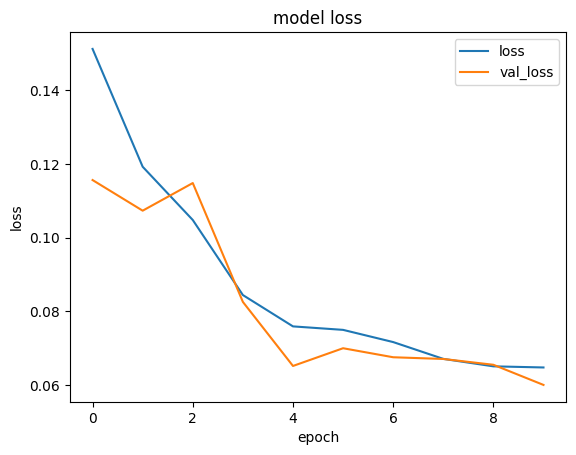

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

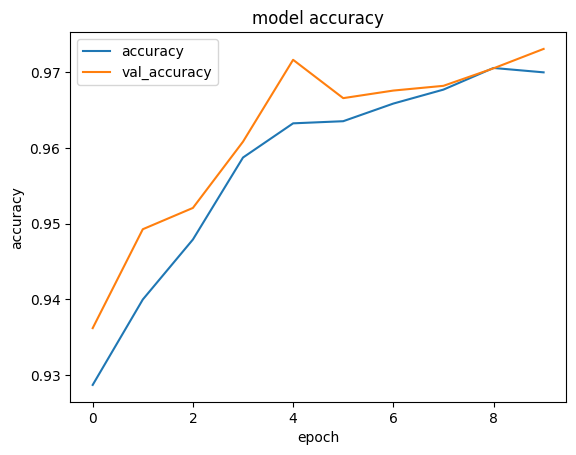

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Evalation

In [16]:
pred_proba = model.predict(X_test)
pred = (pred_proba > 0.5).astype(int)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step


In [17]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    roc_curve,
)

In [18]:
acc = accuracy_score(y_test, pred)
fpr, tpr, _ = roc_curve(y_test, pred_proba)
roc_auc = auc(fpr, tpr)

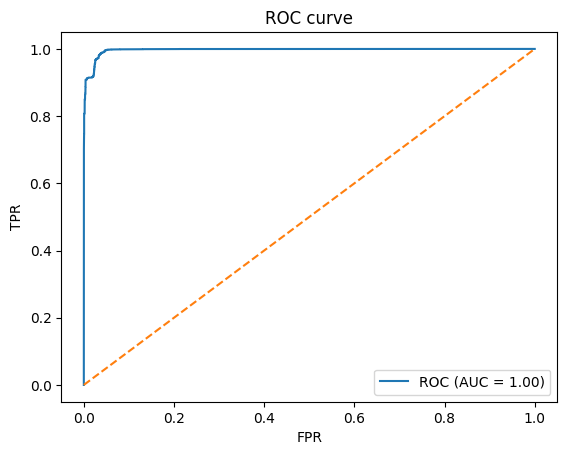

In [19]:
fig = plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')
plt.show()

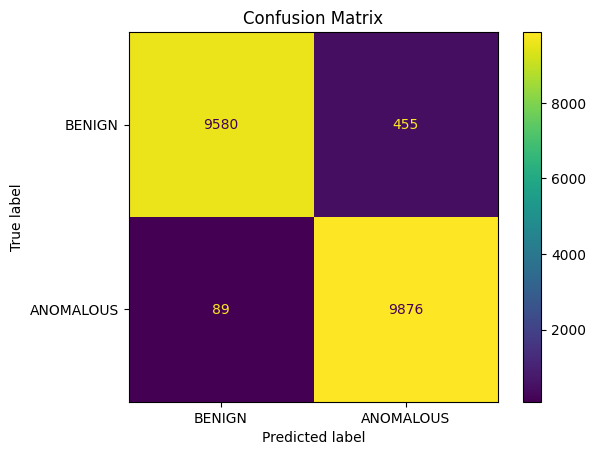

In [20]:
cm = confusion_matrix(y_test, pred)
fig = plt.figure()
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["BENIGN", "ANOMALOUS"])
disp.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()